In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import sys
sys.path.append('C:/Users/mosta/OneDrive - UNCG\Academics/CSC 699 - Thesis/repos/brain_connectome/graphIO')
from graphIO import read_ad_data
from asymmetry import calculate_inter_hemispheric_asymmetry_vector
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
AD_DIR = "C:/Users/mosta/OneDrive - UNCG/Academics/CSC 699 - Thesis/data/curvatures/"
DEVICE = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ATLAS = 160
HIDDEN_DIM = 256
LATENT_DIM = 1000
EPOCHS = 100
ASYMMETRY_METHOD = 'ai'
CCA_COMPONENTS = 2
LEARNING_RATE = 0.00001
BATCH_SIZE = 32

In [3]:
control_matrices, patient_matrices = read_ad_data(AD_DIR)
control_matrices = np.array(control_matrices)
patient_matrices = np.array(patient_matrices)
print("Control matrices shape: ", control_matrices.shape)
print("Patient matrices shape: ", patient_matrices.shape)
print("Count of NaN items in control_matrices:", np.isnan(control_matrices).sum())

Reading adjacency matrices: 100%|██████████| 50/50 [00:00<00:00, 303.91it/s]


Control matrices shape:  (50, 160, 160)
Patient matrices shape:  (50, 160, 160)
Count of NaN items in control_matrices: 0


In [4]:
def normalize_matrices(matrices):
    """
    Normalize each 2D matrix in a 3D array to have zero mean and unit variance.
    
    Args:
    matrices (np.ndarray): A 3D array of shape (n_samples, n_rows, n_cols)
    
    Returns:
    np.ndarray: A normalized 3D array
    """
    n_samples = matrices.shape[0]
    normalized_matrices = np.zeros_like(matrices)
    epsilon = 1e-8
    
    for i in range(n_samples):
        matrix = matrices[i]
        mean = np.mean(matrix)
        std = np.std(matrix)
        normalized_matrices[i] = (matrix - mean) / (std + epsilon)
        
    return normalized_matrices

In [5]:
control_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix, method=ASYMMETRY_METHOD) for matrix in control_matrices])
patient_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix, method=ASYMMETRY_METHOD) for matrix in patient_matrices])
print(control_asymm_vectors.shape, patient_asymm_vectors.shape)

(50, 80) (50, 80)


In [6]:
control_asymm_vectors = normalize_matrices(control_asymm_vectors)
patient_asymm_vectors = normalize_matrices(patient_asymm_vectors)

In [7]:
tensors = {}
tensors['control'] = torch.tensor(control_asymm_vectors.reshape((-1, 1, ATLAS//2)), dtype=torch.float32).unsqueeze(1)
tensors['patient'] = torch.tensor(patient_asymm_vectors.reshape((-1, 1, ATLAS//2)), dtype=torch.float32).unsqueeze(1)

In [8]:
# Define the VAE model
class AsymmetryVAE(nn.Module):
    def __init__(self, input_shape=(1, 1, ATLAS//2), hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM):
        super(AsymmetryVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.flattened_size = 64 * 1 * 80
        
        self.fc1 = nn.Linear(self.flattened_size, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        
        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, self.flattened_size)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 1, 80)),
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        h = torch.relu(self.bn1(self.fc1(h)))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.bn2(self.fc4(z)))
        h = torch.relu(self.fc5(h))
        h = self.decoder(h)
        return h
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

def calculate_mse(dataloader, model):
    model.eval()
    mse_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon, _, _ = model(data)
            mse_loss += nn.functional.mse_loss(recon, data, reduction='sum').item()
    return mse_loss / len(dataloader.dataset)


# Function to get the latent space representation
def get_latent_space(model, data_vector, use_mean=True):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        # Ensure the data is in the correct shape and tensor format
        data_tensor = torch.tensor(data_vector.reshape(1, 1, 1, ATLAS // 2), dtype=torch.float32).to(device)
        # Pass through the encoder to get mu and logvar
        mu, logvar = model.encode(data_tensor)
        if use_mean:
            return mu.cpu().numpy()  # Return the mean as the latent representation
        else:
            # Sample from the distribution using reparameterization trick
            z = model.reparameterize(mu, logvar)
            return z.cpu().numpy()  # Return the sampled latent representation


In [9]:
models = {}
optimizers = {}
for group in ['control', 'patient']:
    models[group] = AsymmetryVAE().to(DEVICE)
    optimizers[group] = optim.Adam(models[group].parameters(), lr=LEARNING_RATE)
    dataset = TensorDataset(tensors[group], tensors[group])
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Training model for group: {group}')
    for epoch in range(1, EPOCHS + 1):
        models[group].train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizers[group].zero_grad()
            recon_batch, mu, logvar = models[group](data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(models[group].parameters(), max_norm=1.0)
            train_loss += loss.item()
            optimizers[group].step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
        avg_train_loss = train_loss / len(dataloader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}')
        
        # Calculate validation MSE
        val_mse = calculate_mse(dataloader, models[group])
        print(f'====> Validation MSE after Epoch {epoch}: {val_mse:.4f}')

Training model for group: control
Train Epoch: 1 [0/50 (0%)]	Loss: 236.651215
====> Epoch: 1 Average loss: 235.2163
====> Validation MSE after Epoch 1: 104.2536
Train Epoch: 2 [0/50 (0%)]	Loss: 231.074112
====> Epoch: 2 Average loss: 231.5395
====> Validation MSE after Epoch 2: 104.4282
Train Epoch: 3 [0/50 (0%)]	Loss: 228.905151
====> Epoch: 3 Average loss: 227.7093
====> Validation MSE after Epoch 3: 104.4341
Train Epoch: 4 [0/50 (0%)]	Loss: 223.945114
====> Epoch: 4 Average loss: 224.1776
====> Validation MSE after Epoch 4: 104.4617
Train Epoch: 5 [0/50 (0%)]	Loss: 220.381927
====> Epoch: 5 Average loss: 220.9493
====> Validation MSE after Epoch 5: 104.5843
Train Epoch: 6 [0/50 (0%)]	Loss: 220.178589
====> Epoch: 6 Average loss: 218.2701
====> Validation MSE after Epoch 6: 104.3419
Train Epoch: 7 [0/50 (0%)]	Loss: 216.823914
====> Epoch: 7 Average loss: 215.4807
====> Validation MSE after Epoch 7: 104.1555
Train Epoch: 8 [0/50 (0%)]	Loss: 212.150818
====> Epoch: 8 Average loss: 212.

In [10]:
data_control = control_asymm_vectors[:np.min([control_asymm_vectors.size, patient_asymm_vectors.size])]
data_patient = patient_asymm_vectors[:np.min([control_asymm_vectors.size, patient_asymm_vectors.size])]

In [11]:
latent_space_control = np.array([get_latent_space(models['control'], vec) for vec in data_control]).reshape((-1, LATENT_DIM))
latent_space_patient = np.array([get_latent_space(models['patient'], vec) for vec in data_patient]).reshape((-1,LATENT_DIM))

In [12]:
input_data_1 = data_control
input_data_2 = data_patient
latent_space_1 = latent_space_control
latent_space_2 = latent_space_patient

In [13]:
# Assuming data_class_1 and data_class_2 are your input datasets
cca = CCA(n_components=CCA_COMPONENTS)
cca_input_1, cca_input_2 = cca.fit_transform(input_data_1, input_data_2)

correlations_input = [np.corrcoef(cca_input_1[:, i], cca_input_2[:, i])[0, 1] for i in range(cca_input_1.shape[1])]
print("Canonical Correlations on Input:", correlations_input)

Canonical Correlations on Input: [1.0, 1.0]


In [14]:
# Assuming latent_space_class_1 and latent_space_class_2 are obtained from VAEs
cca = CCA(n_components=CCA_COMPONENTS)
cca_latent_1, cca_latent_2 = cca.fit_transform(latent_space_1, latent_space_2)

correlations_latent = [np.corrcoef(cca_latent_1[:, i], cca_latent_2[:, i])[0, 1] for i in range(cca_latent_1.shape[1])]
print("Canonical Correlations on Latent Space:", correlations_latent)

Canonical Correlations on Latent Space: [0.9999999999999998, 0.9999999999999997]


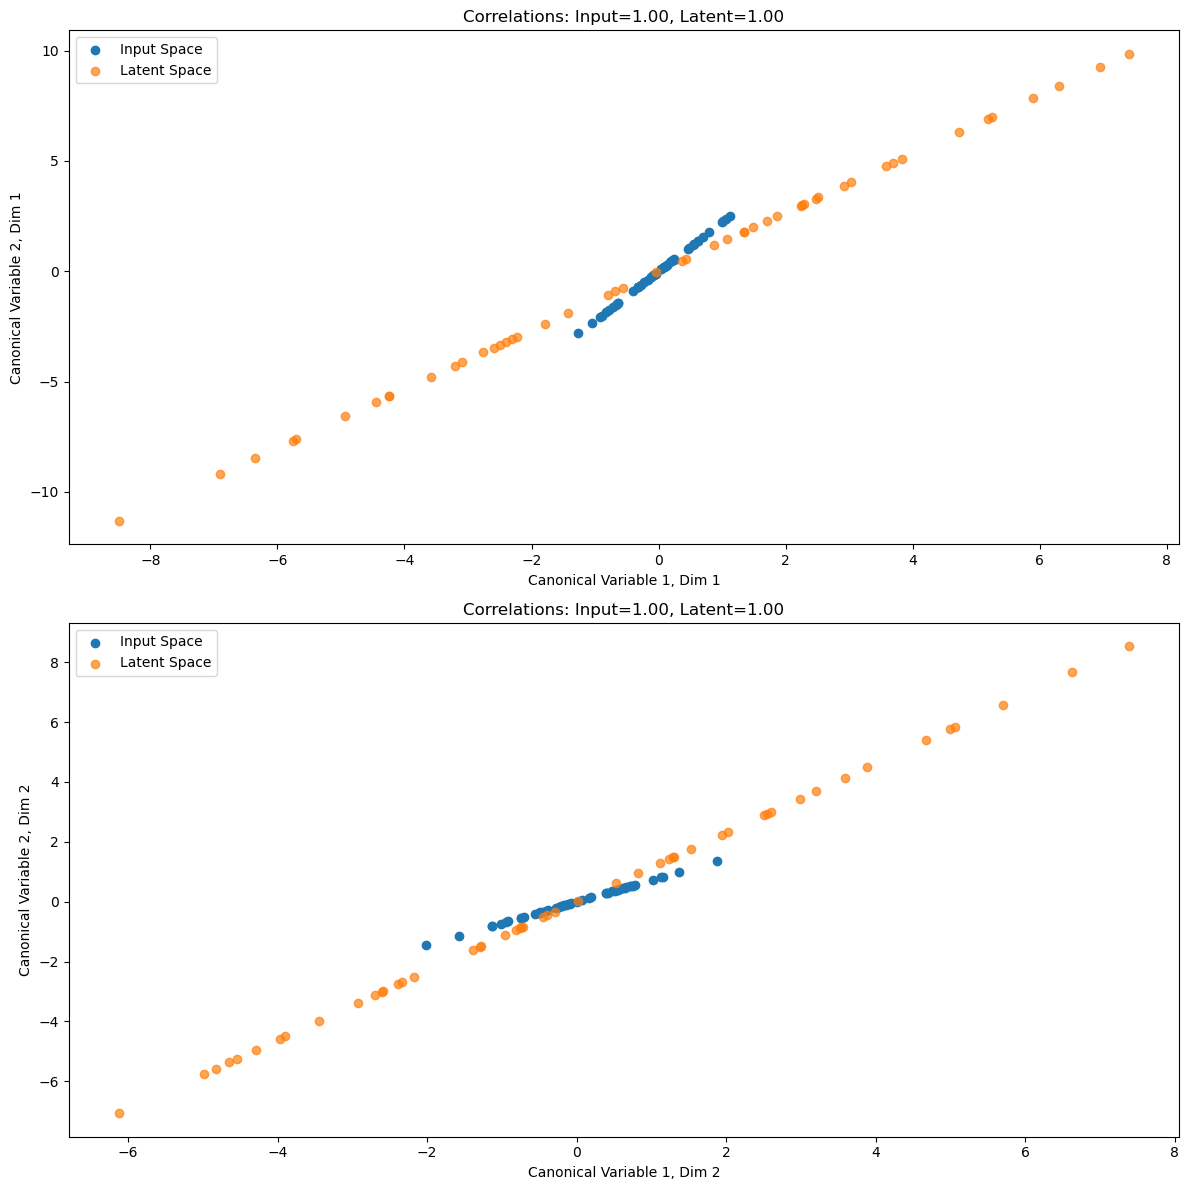

In [15]:
plt.figure(figsize=(12, 12))
for i in range(CCA_COMPONENTS):  # Assuming n_components=2
    plt.subplot(CCA_COMPONENTS, CCA_COMPONENTS//2, i + 1)
    plt.scatter(cca_input_1[:, i], cca_input_2[:, i], label='Input Space')
    plt.scatter(cca_latent_1[:, i], cca_latent_2[:, i], label='Latent Space', alpha=0.7)
    plt.xlabel(f'Canonical Variable 1, Dim {i+1}')
    plt.ylabel(f'Canonical Variable 2, Dim {i+1}')
    plt.title(f'Correlations: Input={correlations_input[i]:.2f}, Latent={correlations_latent[i]:.2f}')
    plt.legend()
plt.tight_layout()
plt.show()